###  Détection Automatique de Genre pour la Carte d'Identité Nationale du Togo

#### Didi Orlog SOSSOU

In [46]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

### Etape 1 : Chargement et exploration des données

In [47]:
# Load the dataset from the CSV file
df = pd.read_csv("dataset_names.csv")

# Shape
print(f"Shape of the dataset: {df.shape}")

# Display the first few rows of the DataFrame
df.head()

Shape of the dataset: (60000, 3)


,firstname,lastname,gender
0,Anani,Wang,1
1,Kwame,Ofori-Atta,1
2,Serge,Li,1
3,Wanda,Obodai,0
4,Rémy,Simon,1


In [48]:
# Check for duplicates
duplicates = df.duplicated(subset=["firstname", "lastname", "gender"])
print(f"Number of duplicate records: {duplicates.sum()}")

Number of duplicate records: 0


### Feature Engineering

In [49]:
import pandas as pd


def analyze_endings(name: str):
    # Features based on typical female and male name endings
    fem_end_1 = int(name[-1:] in ['a', 'e', 'i', 'y'])
    fem_end_2 = int(name[-2:] in [
        'ia', 'ie', 'la', 'na', 'ra', 'sa', 'ta',
        'ne', 'le', 'se', 'te'
    ])
    fem_end_3 = int(name[-3:] in [
        'ine', 'ane', 'ade', 'ette', 'elle',
        'ise', 'ose', 'lyn', 'eth', 'beth', 'uth'
    ])
    fem_total = fem_end_1 + fem_end_2 + fem_end_3
    masc_total = int(name[-1:] in ['o', 'u', 'd', 't', 'r', 's'])
    return fem_end_1, fem_end_2, fem_end_3, fem_total, masc_total

def softness_hardness(name: str):
    # Proportion of soft and hard letters in the name
    soft_letters = set('aeiouyflmnr')
    hard_letters = set('kgpbtdcqxz')
    soft_score = sum(1 for c in name if c in soft_letters) / len(name)
    hard_score = sum(1 for c in name if c in hard_letters) / len(name)
    return soft_score, hard_score

def len_vc_ratio(name: str) -> float:
    # Length times vowel/consonant ratio
    vowels = set('aeiouy')
    num_vowels = sum(1 for c in name if c in vowels)
    num_consonants = sum(1 for c in name if c.isalpha() and c not in vowels)
    return len(name) * (num_vowels / (num_consonants + 1))

def count_recurrent(name: str) -> int:
    # Number of letters appearing more than once
    return sum(name.count(l) > 1 for l in set(name))

def second_half_vowel_density(name: str) -> float:
    # Vowel density in the second half of the name
    vowels = set('aeiouy')
    half = name[len(name)//2:]
    return sum(1 for c in half if c in vowels) / len(half) if half else 0.0

def count_fem_bigrams(name: str) -> int:
    # Count of female-typical bigrams
    fem_bigrams = {'ie', 'ia', 'el', 'in', 'an', 'ar', 'et', 'le'}
    return sum(1 for i in range(len(name) - 1)
                if name[i:i+2] in fem_bigrams)

def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform feature engineering on the given DataFrame containing names.
    Extracts various linguistically inspired features from the 'firstname' column.
    """
    vowels = set('aeiouy')

    # Gendered ending features
    df[['firstname_fem_end_1',
        'firstname_fem_end_2',
        'firstname_fem_end_3',
        'firstname_fem_total',
        'firstname_masc_total'
    ]] = df['firstname'].apply(lambda x: pd.Series(analyze_endings(x)))

    # Ratio of feminine to masculine endings
    df['firstname_ending_ratio'] = (
        df['firstname_fem_total'] /
        (df['firstname_masc_total'] + 1)
    )

    # Softness and hardness features
    df[['firstname_softness', 'firstname_hardness']] = df['firstname'].apply(
        lambda x: pd.Series(softness_hardness(x))
    )

    # Name ends with a vowel
    df['firstname_ends_with_vowel'] = df['firstname'].apply(
        lambda x: int(x[-1] in vowels)
    )

    # Length × vowel/consonant ratio
    df['fn_len_vc'] = df['firstname'].apply(len_vc_ratio)

    # Count of recurrent letters
    df['firstname_recurrent_letters'] = df['firstname'].apply(count_recurrent)

    # Vowel density in the second half of the name
    df['firstname_second_vowel_density'] = df['firstname'].apply(
        second_half_vowel_density
    )

    # Female-typical bigram count
    df['firstname_fem_bigrams'] = df['firstname'].apply(count_fem_bigrams)

    return df

# Apply feature engineering to the DataFrame and visualize the results
df = feature_engineering(df)
df.head()

,firstname,lastname,gender,firstname_fem_end_1,firstname_fem_end_2,firstname_fem_end_3,firstname_fem_total,firstname_masc_total,firstname_ending_ratio,firstname_softness,firstname_hardness,firstname_ends_with_vowel,fn_len_vc,firstname_recurrent_letters,firstname_second_vowel_density,firstname_fem_bigrams
0,Anani,Wang,1,1,0,0,1,0,1.0,0.8,0.0,1,2.5,1,0.666667,1
1,Kwame,Ofori-Atta,1,1,0,0,1,0,1.0,0.6,0.0,1,2.5,0,0.666667,0
2,Serge,Li,1,1,0,0,1,0,1.0,0.6,0.2,1,2.5,1,0.333333,0
3,Wanda,Obodai,0,1,0,0,1,0,1.0,0.6,0.2,1,2.5,1,0.333333,1
4,Rémy,Simon,1,1,0,0,1,0,1.0,0.5,0.0,1,1.0,0,0.500000,0


### Etape 2 : Préparation des données et séparation des ensembles d'entraînement et de test

In [50]:
# Split the dataset into training and testing sets
y = df["gender"]
X = df.drop(columns=['gender', 'lastname', 'firstname'])
X.head()

,firstname_fem_end_1,firstname_fem_end_2,firstname_fem_end_3,firstname_fem_total,firstname_masc_total,firstname_ending_ratio,firstname_softness,firstname_hardness,firstname_ends_with_vowel,fn_len_vc,firstname_recurrent_letters,firstname_second_vowel_density,firstname_fem_bigrams
0,1,0,0,1,0,1.0,0.8,0.0,1,2.5,1,0.666667,1
1,1,0,0,1,0,1.0,0.6,0.0,1,2.5,0,0.666667,0
2,1,0,0,1,0,1.0,0.6,0.2,1,2.5,1,0.333333,0
3,1,0,0,1,0,1.0,0.6,0.2,1,2.5,1,0.333333,1
4,1,0,0,1,0,1.0,0.5,0.0,1,1.0,0,0.500000,0


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((42000, 13), (18000, 13), (42000,), (18000,))

### Etape 3 :  1- Entrainement du premier modèle : Random Forest Classifier

In [52]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

### Etape 3 :  2- Entrainement du second modèle : CatBoost Classifier

In [53]:
# CatBoost Classifier
catboost_classifier = CatBoostClassifier(random_seed=42, eval_metric='Accuracy', iterations=200)
catboost_classifier.fit(X_train, y_train, verbose=0, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Etape 4 : 1- Evaluation du RandoomForest  sur les ensembles d'entraînement et de test

In [54]:
# Predictions on training set
y_train_pred = rf_classifier.predict(X_train)
# Predictions on testing set
y_test_pred = rf_classifier.predict(X_test)

# Training set metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Testing set metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Display the metrics
print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print("\nTesting Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

Training Set Metrics:
Accuracy: 0.9618
Precision: 0.9471
Recall: 0.9782
F1-Score: 0.9624

Testing Set Metrics:
Accuracy: 0.9586
Precision: 0.9445
Recall: 0.9746
F1-Score: 0.9593


### Etape 4 : 2- Evaluation du RandomForest sur les noms de la salle (test_dataset.csv)

In [55]:
test_data =  pd.read_csv("test_dataset.csv")
# Feature engineering on the test data
test_data = feature_engineering(test_data)
test_data_ = test_data.drop(columns=["gender", "lastname", "firstname"])

# Predictions on the test data
test_predictions = rf_classifier.predict(test_data_)

# metrics on the test data
print("Metrics while testing against class data")
test_accuracy = accuracy_score(test_data["gender"], test_predictions)
print(f"Class Test Data Accuracy: {test_accuracy:.4f}")
test_precision = precision_score(test_data["gender"], test_predictions)
print(f"Class Test Data Precision: {test_precision:.4f}")
test_recall = recall_score(test_data["gender"], test_predictions)
print(f"Class Test Data Recall: {test_recall:.4f}")
test_f1 = f1_score(test_data["gender"], test_predictions)
print(f"Class Test Data F1-Score: {test_f1:.4f}")

Metrics while testing against class data
Class Test Data Accuracy: 0.9783
Class Test Data Precision: 1.0000
Class Test Data Recall: 0.9744
Class Test Data F1-Score: 0.9870


### Etape 4 : 3 - Evaluation du Catboost sur les ensembles d'entraînement et de test


CatBoost Training Set Metrics:
Accuracy: 0.9616
Precision: 0.9431
Recall: 0.9826
F1-Score: 0.9624

CatBoost Testing Set Metrics:
Accuracy: 0.9589
Precision: 0.9410
Recall: 0.9794
F1-Score: 0.9598


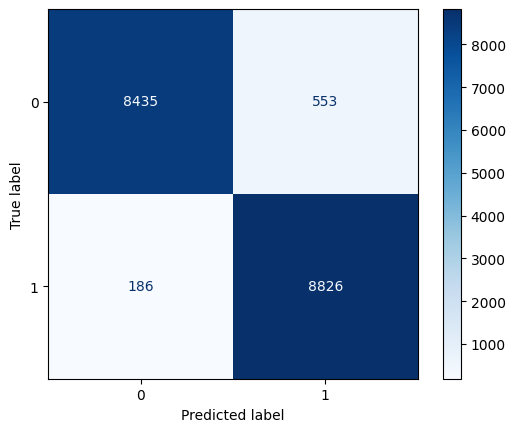

In [56]:
# Evaluate catboost on train and test set
y_train_catboost_pred = catboost_classifier.predict(X_train)
y_test_catboost_pred = catboost_classifier.predict(X_test)

# Metrics for CatBoost on training set
train_catboost_accuracy = accuracy_score(y_train, y_train_catboost_pred)
train_catboost_precision = precision_score(y_train, y_train_catboost_pred)
train_catboost_recall = recall_score(y_train, y_train_catboost_pred)
train_catboost_f1 = f1_score(y_train, y_train_catboost_pred)
# Metrics for CatBoost on testing set
test_catboost_accuracy = accuracy_score(y_test, y_test_catboost_pred)
test_catboost_precision = precision_score(y_test, y_test_catboost_pred)
test_catboost_recall = recall_score(y_test, y_test_catboost_pred)
test_catboost_f1 = f1_score(y_test, y_test_catboost_pred)
# Display CatBoost metrics
print("\nCatBoost Training Set Metrics:")
print(f"Accuracy: {train_catboost_accuracy:.4f}")
print(f"Precision: {train_catboost_precision:.4f}")
print(f"Recall: {train_catboost_recall:.4f}")
print(f"F1-Score: {train_catboost_f1:.4f}")
print("\nCatBoost Testing Set Metrics:")
print(f"Accuracy: {test_catboost_accuracy:.4f}")
print(f"Precision: {test_catboost_precision:.4f}")
print(f"Recall: {test_catboost_recall:.4f}")
print(f"F1-Score: {test_catboost_f1:.4f}")

# Confusion Matrix for CatBoost on the test set
ConfusionMatrixDisplay.from_estimator(
    catboost_classifier, X_test, y_test, cmap=plt.cm.Blues
)

### Etape 4 : 4 - Evaluation du Catboost sur les noms de la salle (test_dataset.csv)

In [57]:
# Predictions on the test data
test_predictions = catboost_classifier.predict(test_data_)

# Metrics on the test data
test_accuracy = accuracy_score(test_data["gender"], test_predictions)
print(f"Class Test Data Accuracy using Catboost: {test_accuracy:.4f}")
test_precision = precision_score(test_data["gender"], test_predictions)
print(f"Class Test Data Precision using Catboost: {test_precision:.4f}")
test_recall = recall_score(test_data["gender"], test_predictions)
print(f"Class Test Data Recall using Catboost: {test_recall:.4f}")
test_f1 = f1_score(test_data["gender"], test_predictions)
print(f"Class Test Data F1-Score using Catboost: {test_f1:.4f}")

Class Test Data Accuracy using Catboost: 1.0000
Class Test Data Precision using Catboost: 1.0000
Class Test Data Recall using Catboost: 1.0000
Class Test Data F1-Score using Catboost: 1.0000


### Etape 6 : Prédiction pour une personne spécifique

In [59]:
def predict_gender(full_name):
    """
    Predicts the gender based on the given full name using a trained random forest classifier.

    Args:
        full_name (str): The full name, with first name followed by last name, separated by a space.

    Returns:
        int: 1 if the model predicts Male, 0 if the model predicts Female.

    Raises:
        ValueError: If the input does not contain at least a first name and a last name.
    """

    # Split the input into first name and last name
    parts = full_name.strip().split()
    if len(parts) < 2:
        raise ValueError("Please provide both first name and last name, separated by a space.")
    first_name = parts[0]
    last_name = " ".join(parts[1:])

    first_name = first_name.lower()

    # Create a DataFrame for model input
    input_data = pd.DataFrame({
        'firstname': [first_name],
        'lastname': [last_name]
    })

    # Feature engineering for the model
    input_data = feature_engineering(input_data)

    # Remove columns not used by the model
    input_data_ = input_data.drop(columns=['lastname', 'firstname'])

    # Predict gender using the trained classifier
    prediction = catboost_classifier.predict(input_data_)

    # Return 1 for Male, 0 for Female
    return 1 if prediction[0] == 1 else 0

# Test wirh Ruth AYITTEY
print("Sexe de Ruth AYITTEY : ", "Homme" if predict_gender("Ruth AYITTEY") == 1 else "Femme")

Sexe de Ruth AYITTEY :  Femme
